In [1]:
# !pip install torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
# 1. Define Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

    def forward(self, x):
        x = x.view(-1, 28*28)
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

In [4]:
# 2. Reparameterization
def sample_z(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

In [5]:
# 3. Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 400)
        self.fc_out = nn.Linear(400, 28*28)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        x_hat = torch.sigmoid(self.fc_out(h))
        return x_hat.view(-1, 1, 28, 28)

In [6]:
# 4. VAE
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = sample_z(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [7]:
# 5. Loss
def vae_loss(x, x_hat, mu, logvar):
    recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [8]:
# 6. Setup
latent_dim = 2
model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 7. Load Data
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:11<00:00, 851kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 72.8kB/s]
100%|██████████| 1.65M/1.65M [00:04<00:00, 356kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.48MB/s]


In [9]:
# 8. Train
model.train()
for epoch in range(10):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x)
        loss = vae_loss(x, x_hat, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 190.1049
Epoch 2, Loss: 166.7665
Epoch 3, Loss: 162.7400
Epoch 4, Loss: 160.5888
Epoch 5, Loss: 159.0786
Epoch 6, Loss: 157.8320
Epoch 7, Loss: 156.8783
Epoch 8, Loss: 155.9933
Epoch 9, Loss: 155.3149
Epoch 10, Loss: 154.5953


In [11]:
torch.save(model, "VAE.pth")

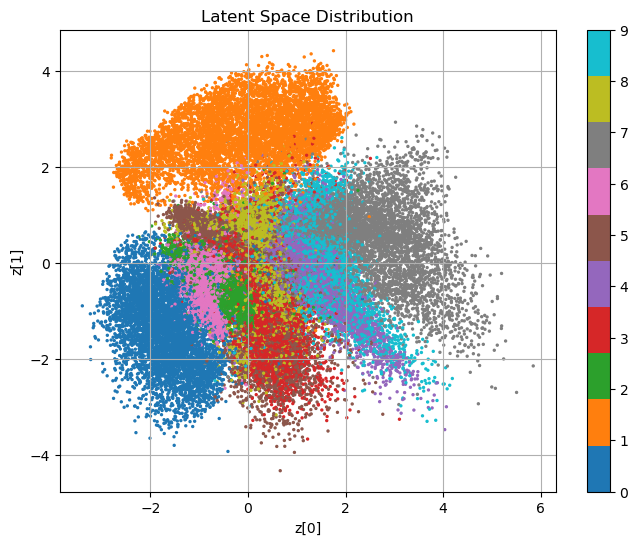

In [10]:
# 9. Plot Latent Space
model.eval()
latents, labels = [], []
with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        mu, _ = model.encoder(x)
        latents.append(mu.cpu())
        labels.append(y)
latents = torch.cat(latents)
labels = torch.cat(labels)

plt.figure(figsize=(8, 6))
plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', s=2)
plt.colorbar()
plt.title("Latent Space Distribution")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.grid(True)
plt.show()

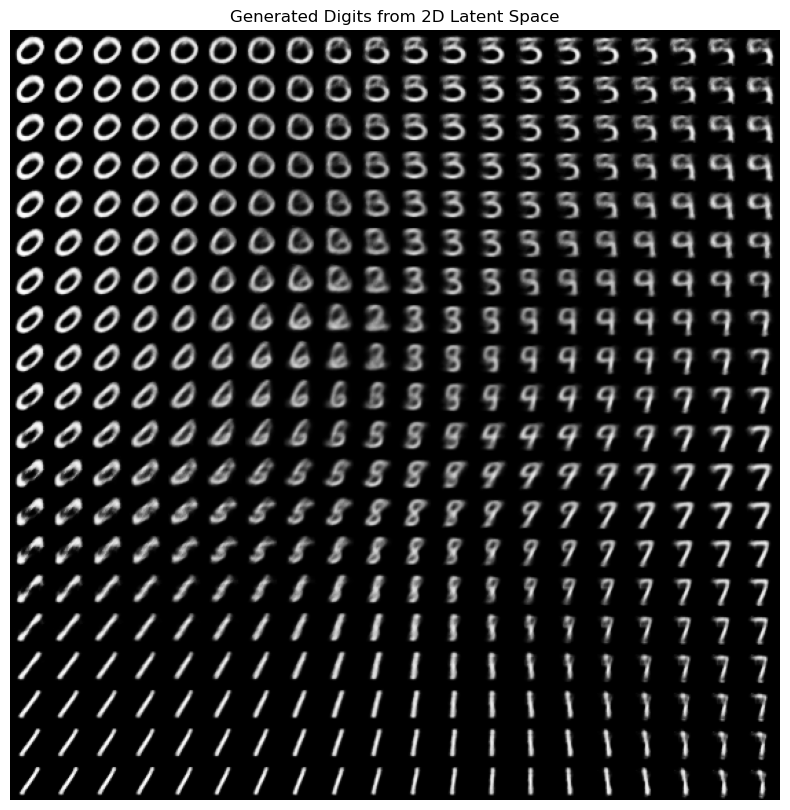

In [12]:
# Sample from the latent space and generate digits
import numpy as np

# Create a grid of latent points
n = 20  # how many digits per axis
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Create linearly spaced coordinates between -3 and 3
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

model.eval()
with torch.no_grad():
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            x_decoded = model.decoder(z_sample)
            digit = x_decoded[0].cpu().numpy().squeeze()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

# Plot the generated digit grid
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="gray")
plt.title("Generated Digits from 2D Latent Space")
plt.axis("off")
plt.show()

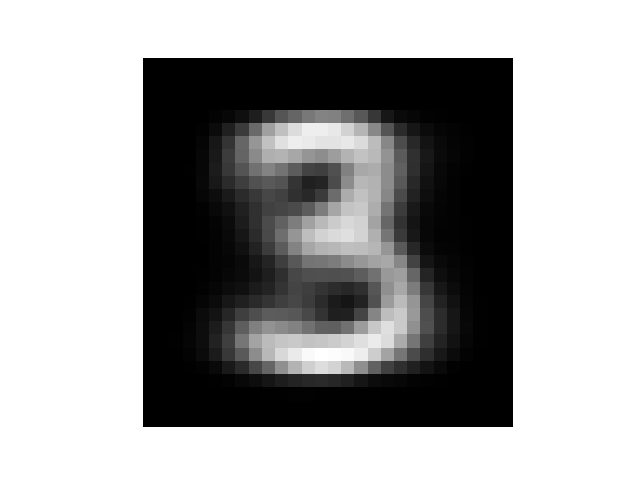

In [13]:
import matplotlib.animation as animation
from IPython.display import HTML

# Function to interpolate between two latent vectors
def interpolate(z1, z2, steps=30):
    return [(1 - t) * z1 + t * z2 for t in torch.linspace(0, 1, steps)]

# Pick two random latent points
z1 = torch.randn(1, 2).to(device)
z2 = torch.randn(1, 2).to(device)
interpolated = interpolate(z1, z2, steps=60)

# Generate digits for each interpolated point
frames = []
model.eval()
with torch.no_grad():
    for z in interpolated:
        x_hat = model.decoder(z)
        img = x_hat[0].cpu().numpy().squeeze()
        frames.append(img)

# Create animation
fig, ax = plt.subplots()
im = ax.imshow(frames[0], cmap='gray')
ax.axis('off')

def update(i):
    im.set_data(frames[i])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=100, blit=True)

# Display animation in notebook
plt.close(fig)
HTML(ani.to_jshtml())
ani.save("animation.gif", writer="pillow")
from IPython.display import Image
Image("animation.gif")

In [14]:
# Encoder with Conv layers
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 4, 2, 1)  # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1) # 14x14 -> 7x7
        self.fc1 = nn.Linear(64*7*7, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

# Decoder with ConvTranspose layers
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 64*7*7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 4, 2, 1) # 7x7 -> 14x14
        self.deconv2 = nn.ConvTranspose2d(32, 1, 4, 2, 1)  # 14x14 -> 28x28

    def forward(self, z):
        z = F.relu(self.fc(z))
        z = F.relu(self.fc2(z))
        z = z.view(-1, 64, 7, 7)
        z = F.relu(self.deconv1(z))
        z = torch.sigmoid(self.deconv2(z))
        return z

In [15]:
# VAE combining encoder and decoder
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [16]:
# Train ConvVAE
latent_dim = 2
model = ConvVAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
# 8. Train
model.train()
for epoch in range(10):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x)
        loss = vae_loss(x, x_hat, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 184.0614
Epoch 2, Loss: 159.7877
Epoch 3, Loss: 155.4524
Epoch 4, Loss: 153.0510
Epoch 5, Loss: 151.2872
Epoch 6, Loss: 150.0421
Epoch 7, Loss: 148.9421
Epoch 8, Loss: 147.9894
Epoch 9, Loss: 147.3058
Epoch 10, Loss: 146.5921


In [18]:
torch.save(model, "CONV_VAE.pth")

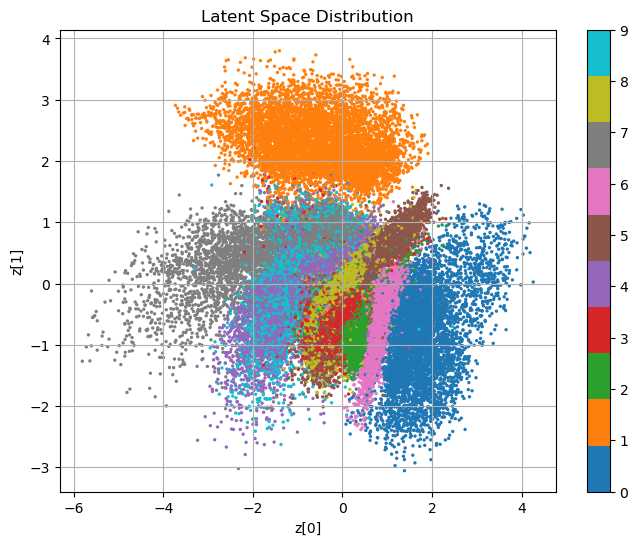

In [19]:
# 9. Plot Latent Space
model.eval()
latents, labels = [], []
with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        mu, _ = model.encoder(x)
        latents.append(mu.cpu())
        labels.append(y)
latents = torch.cat(latents)
labels = torch.cat(labels)

plt.figure(figsize=(8, 6))
plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', s=2)
plt.colorbar()
plt.title("Latent Space Distribution")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.grid(True)
plt.show()

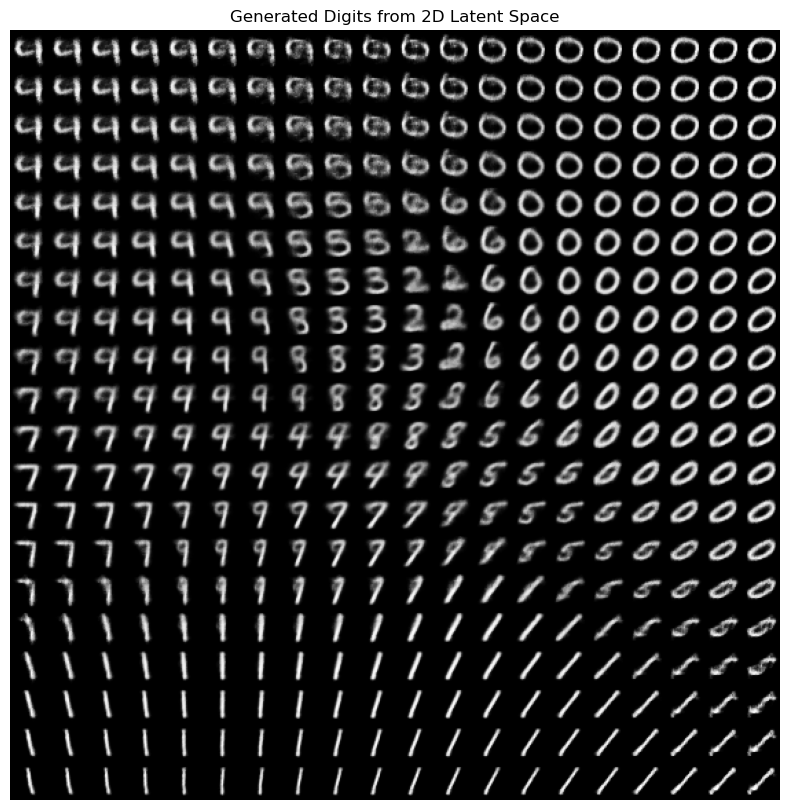

In [20]:
# Create a grid of latent points
n = 20  # how many digits per axis
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Create linearly spaced coordinates between -3 and 3
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

model.eval()
with torch.no_grad():
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            x_decoded = model.decoder(z_sample)
            digit = x_decoded[0].cpu().numpy().squeeze()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

# Plot the generated digit grid
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="gray")
plt.title("Generated Digits from 2D Latent Space")
plt.axis("off")
plt.show()

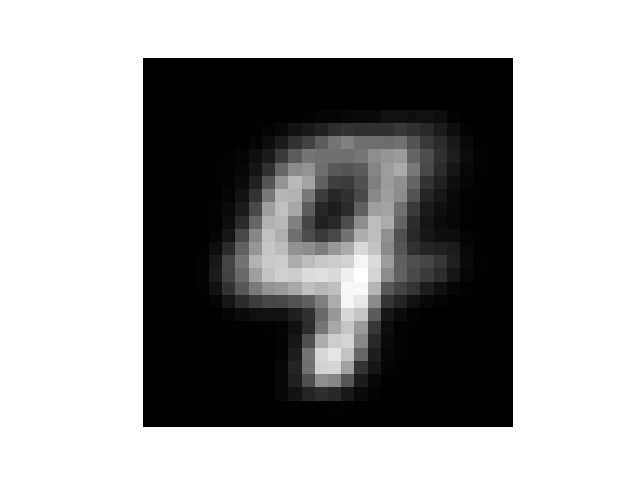

In [21]:
# Function to interpolate between two latent vectors
def interpolate(z1, z2, steps=30):
    return [(1 - t) * z1 + t * z2 for t in torch.linspace(0, 1, steps)]

# Pick two random latent points
z1 = torch.randn(1, 2).to(device)
z2 = torch.randn(1, 2).to(device)
interpolated = interpolate(z1, z2, steps=60)

# Generate digits for each interpolated point
frames = []
model.eval()
with torch.no_grad():
    for z in interpolated:
        x_hat = model.decoder(z)
        img = x_hat[0].cpu().numpy().squeeze()
        frames.append(img)

# Create animation
fig, ax = plt.subplots()
im = ax.imshow(frames[0], cmap='gray')
ax.axis('off')

def update(i):
    im.set_data(frames[i])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=100, blit=True)

# Display animation in notebook
plt.close(fig)
HTML(ani.to_jshtml())
ani.save("animation_conv.gif", writer="pillow")
from IPython.display import Image
Image("animation_conv.gif")


In [22]:
# --- Conditional VAE (Convolutional) ---

class ConvEncoder(nn.Module):
    def __init__(self, latent_dim, label_dim):
        super().__init__()
        self.label_dim = label_dim
        self.conv1 = nn.Conv2d(1 + label_dim, 32, 4, 2, 1)  # Condition on label by channel-wise concat
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    def forward(self, x, y):
        y = y[:, :, None, None].expand(-1, -1, 28, 28)  # shape: [B, 10, 28, 28]
        x = torch.cat([x, y], dim=1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

class ConvDecoder(nn.Module):
    def __init__(self, latent_dim, label_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim + label_dim, 256)
        self.fc2 = nn.Linear(256, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.deconv2 = nn.ConvTranspose2d(32, 1, 4, 2, 1)

    def forward(self, z, y):
        z = torch.cat([z, y], dim=1)
        z = F.relu(self.fc(z))
        z = F.relu(self.fc2(z))
        z = z.view(-1, 64, 7, 7)
        z = F.relu(self.deconv1(z))
        z = torch.sigmoid(self.deconv2(z))
        return z

In [23]:
class ConditionalConvVAE(nn.Module):
    def __init__(self, latent_dim=2, label_dim=10):
        super().__init__()
        self.encoder = ConvEncoder(latent_dim, label_dim)
        self.decoder = ConvDecoder(latent_dim, label_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        mu, logvar = self.encoder(x, y)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z, y), mu, logvar

In [24]:
def loss_fn(x, x_hat, mu, logvar):
    recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [25]:
latent_dim = 2
label_dim = 10
model = ConditionalConvVAE(latent_dim, label_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

transform = transforms.ToTensor()
dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [26]:
def one_hot(labels, num_classes=10):
    labels = labels.to(torch.long)  
    return torch.eye(num_classes, device=labels.device)[labels]

In [28]:
model.train()
for epoch in range(10):
    total_loss = 0
    for x, y in loader:
        x = x.to(device)
        y_oh = one_hot(y).to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = model(x, y_oh)
        loss = loss_fn(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(loader.dataset):.4f}")

Epoch 1, Loss: 186.3515
Epoch 2, Loss: 140.9002
Epoch 3, Loss: 134.1389
Epoch 4, Loss: 132.1621
Epoch 5, Loss: 131.2123
Epoch 6, Loss: 130.6185
Epoch 7, Loss: 130.1391
Epoch 8, Loss: 129.7827
Epoch 9, Loss: 129.5104
Epoch 10, Loss: 129.2440


In [29]:
torch.save(model, "Cond_Conv_VAE.pth")

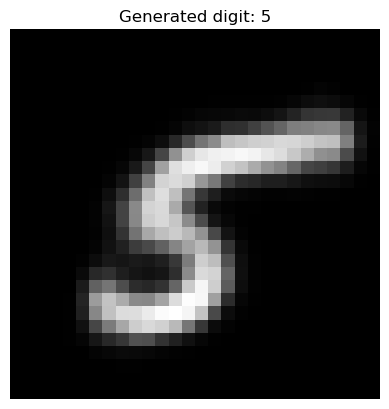

In [30]:
# --- Generate a specific digit ---
def generate_digit(model, digit, latent_dim=2):
    model.eval()
    with torch.no_grad():
        y = torch.tensor([digit], device=device)
        y_oh = one_hot(y)
        z = torch.randn(1, latent_dim, device=device)
        sample = model.decoder(z, y_oh)
        plt.imshow(sample.cpu().squeeze(), cmap='gray')
        plt.title(f"Generated digit: {digit}")
        plt.axis('off')
        plt.show()

# Example: generate a 9
generate_digit(model, digit=5)